# Doodle CNN
A neural network to predict what was drawn, given 28x28 input picture pixel data (784)\
Trained with quickdraw-dataset

In [ ]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import random
import zipfile
from contextlib import ExitStack
from datetime import datetime

### Step 1: Get TFRecord dataset filepaths

Get all data from .npy files, store in tensoflow Dataset object. Shuffle the data, and save to a .tfrecord file for easy access in the future

In [ ]:
def create_example_protobuff(image, label):
    # convert to binary string format for Example protobuf
    image_data = tf.io.serialize_tensor(image)

    return tf.train.Example(
        features=tf.train.Features(
            feature={
                'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data.numpy()])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
            }
        )
    )

In [ ]:

def write_tfrecords(name, dataset):
    paths = f'{name}.tfrecord'
    with ExitStack() as stack:
        writer = stack.enter_context(tf.io.TFRecordWriter(path))
        
        # create example protobuffs from instances
        for index, (image, label) in dataset.enumerate():
            example = create_example_protobuff(image, np.uint8(label))
            writer.write(example.SerializeToString())
    return paths

In [ ]:
all_files = glob.glob("data/*")

NUM_FILES=0
def load_data():
    class_names = []
    all_filepaths = []

    # load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        # data is 784, but need to reshape to 28x28 for CNN
        data = data.reshape((data.shape[0], 28, 28)).astype(np.uint8)
        labels = np.full(data.shape[0], idx)
        
        # convert numpy array to Tensorflow Dataset object
        dataset = tf.data.Dataset.from_tensor_slices((data, labels)).shuffle(data.shape[0])

        # write Dataset to files
        filepaths = write_tfrecords(f"doodle-{idx}", dataset)
        all_filepaths.append(filepaths)
        
        # class name will be name of file e.g. 'fork.npy' is 'fork'
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)
        
        # logging
        global NUM_FILES
        NUM_FILES+=1
        # every 35 files
        if NUM_FILES % 35 == 0:
            print(f'{NUM_FILES} file npy to tfrecord')
        
    return all_filepaths, class_names
    
filepaths, class_names = load_data()

In [ ]:
class DoodleDataset:
  '''
    Create TFRecordDataset from filepaths
  '''
  def __init__(self, filepaths, shuffle_buffer_size, batch_size=128):
    self.filepaths = filepaths
    self.shuffle_buffer_size = shuffle_buffer_size
    self.batch_size = batch_size
  
  # parse serialized Example protobuf
  def preprocess(self, tfrecord):
    # to parse we need the feature description of the protobuf
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=""),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=1)
    }
    parsed_example = tf.io.parse_single_example(tfrecord, feature_description)
    image = tf.io.parse_tensor(parsed_example['image'], out_type=tf.uint8)
    # now reshape
    image = tf.reshape(image, [28, 28])
    return image, parsed_example['label']


  def create_dataset(self):
    # reading all filepaths in parallel
    dataset = tf.data.TFRecordDataset(self.filepaths, num_parallel_reads=len(self.filepaths))

    # shuffling
    dataset = dataset.shuffle(selfshuffle_buffer_size)
        
    # parse serialized Dataset
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(self.batch_size)
    # be 1 batch ahead
    return dataset.prefetch(1)



In [ ]:
# create doodle dataset object
doodle_dataset = DoodleDataset(filepaths, shuffle_buffer_size=4000000)

# need good shuffling so set the shuffle size very large (even though it takes longer)
train_set = doodle_dataset.create_dataset()

# take some samples for val and test (don't need a lot percentage wise)
val_set = train_set.take(50000)
test_set = train_set.take(50000)

### Now that we have and can save and load from tfrecord files, lets see some example images that we loaded!

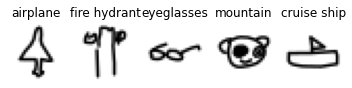

In [ ]:
import matplotlib.pyplot as plt
for (X, y) in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(class_names[y[i].numpy()])

In [ ]:
# clear session from possible previous models
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

# standardization
# for each feature, subract the mean and divide by standard deviation
# epsilon for divide by 0
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

standardization = Standardization(input_shape=[28, 28, 1])

# have to adapt to dataset
# this will allow it to use the right mean and std dev for each feature
sample_image_batches = train_set.take(1000).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

## Step 2
Machine learning model

### Architecture

Using Google's ResNet-34 Architecture

In [ ]:
from functools import partial


DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.filters=filters
        self.strides=strides
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'strides': self.strides,
            'activation': self.activation,
        })
        return config

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = keras.models.Sequential()
model.add(tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)))

model.add(DefaultConv2D(64, kernel_size=7, strides=2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64

# 3 ResidualUnits with 64 feature maps, then 4 ResidualUnits with 128 feature maps, then . . .
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(346, activation="softmax"))
 
    
    
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
model_filepath = "/content/drive/MyDrive/DoodleData/my_doodle_model.h5"

# create log directory for tensorboard
logs = os.path.join(os.curdir, "my_logs", "run_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=logs, histogram_freq=1, profile_batch=10, update_freq=10000)
# stop if model doesn't improve after 2 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2)
# save best model after each epoch
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=model_filepath,
                                                      save_best_only=True,
                                                      save_freq='epoch',
                                                      monitor='accuracy')

callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]



In [ ]:
history = model.fit(train_set, epochs=5, verbose=1, validation_data=val_set, callbacks=callbacks)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006